# Import thư viện

Thư viện cho xử lý dữ liệu

In [ ]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm  # for progress bar
from sklearn.model_selection import train_test_split
import random

Thư viện cho encoder

In [ ]:
from transformers import CLIPTokenizer, CLIPProcessor, AutoTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader

Thư viện cho Trainning

In [ ]:
from pyexpat import features
import copy
import math
from sys import prefix
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from transformers import CLIPModel, AutoConfig, AutoModel

import argparse
import os

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import DataLoader


---

# Sử lý dữ liệu đầu vào

In [ ]:
class HatefulMemesDataset(Dataset):
    def __init__(self, root_folder, image_folder, split='train', labels='original', image_size=224):
        super(HatefulMemesDataset, self).__init__()
        
        # path setup
        self.image_folder = image_folder
        self.root_folder = root_folder
        
        # data to variable property
        self.split = split
        self.labels = labels
        self.image_size = image_size

        if split == 'train':
            self.info_file = os.path.join(root_folder, 'train.jsonl')
        elif split == 'validate': 
            self.info_file = os.path.join(root_folder, 'dev.jsonl')
        else:
            self.info_file = os.path.join(root_folder, 'test.jsonl')

        self.df = pd.read_json(self.info_file, lines=True)
        
    def __len__(self):
        return len(self.df)
        
    # {"id":58371,"img":"img\/58371.png","label":0,"text":"when you suck at photoshop"}
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_fn = row['img'].split('/')[-1].split('.')[0]

        item = {}
        item['image'] = Image.open(f"{self.root_folder}/{self.image_folder}/{img_fn}.png").convert('RGB').resize((self.image_size, self.image_size))
        item['caption'] = row['text']
        item['label'] = row['label']
        return item

class HarmFulV1(Dataset):
    def __init__(self, root_folder, image_folder, split='train', labels='original', image_size=224):
        super(Dataset, self).__init__()
        
        # path setup
        self.image_folder = image_folder
        self.root_folder = root_folder
        
        # data to variable property
        self.split = split
        self.labels = labels
        self.image_size = image_size

        self.info_file = os.path.join(root_folder, 'label_E_format.json')

        self.df = pd.read_json(self.info_file, encoding='ISO-8859-1')
        
        
        # Split data: 80% train, 20% test_val
        train_df, test_val_df = train_test_split(self.df, test_size=0.2, random_state=42)
        
        # Split test_val: 50% for test and 50% for validate (10% each of original dataset)
        val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)
        
        # Assign the right subset based on `split` parameter
        if split == 'train':
            self.df = train_df
        elif split == 'validate':
            self.df = val_df
        elif split == 'test':
            self.df = test_df
        
        
    def __len__(self):
        return len(self.df)
        
    # {"id":58371,"img":"img\/58371.png","label":0,"text":"when you suck at photoshop"}
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_fn = row['image']
        
        item = {}

        
        try:
            image_path = os.path.join(self.root_folder, self.image_folder, img_fn)
            item['image'] = Image.open(image_path).convert('RGB').resize((self.image_size, self.image_size))
        except OSError:
            print(f"Warning: Image file {img_fn} is corrupted and could not be loaded.")
            random_number = random.randint(100, 3000)
            
            image_path = os.path.join(self.root_folder, self.image_folder, f'image_ ({random_number}).jpg')
            item['image'] = Image.open(image_path).convert('RGB').resize((self.image_size, self.image_size))  # Or return a placeholder image if required
            
        item['caption'] = row['text']
        item['label'] = row['label']
        return item



Thử nghiệm

In [ ]:
root_folder = '/kaggle/input/harmfulv1-0/archive_C_E'  # Loại bỏ dấu '/' ở cuối
image_folder = 'Eimages/Eimages/Eimages'
item={}
random_number = random.randint(100, 3000)

# Kết hợp đúng các phần của đường dẫn
image_path = os.path.join(root_folder, image_folder, f'image_ ({random_number}).jpg')

# Mở ảnh
item['image'] = Image.open(image_path).convert('RGB').resize((224, 224)) 
print(item)

---

# Sử lý encoder

In [ ]:
class CustomCollator(object):
    def __init__(self, args, image_size=224, multilingual_tokenizer_path='none'):
        self.args = args
        self.image_size = image_size
        
        # args.clip_pretrained_model lựa chọn model Encoder có sẵn trên HuggingFace
        self.image_processor = CLIPProcessor.from_pretrained(args.clip_pretrained_model)
        self.text_processor = CLIPTokenizer.from_pretrained(args.clip_pretrained_model)

        # multilingual_tokenizer_path là tên model ngôn ngữ mà ae muốn sử dụng
        # VD: tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
        if multilingual_tokenizer_path != 'none':
            self.text_processor = AutoTokenizer.from_pretrained(multilingual_tokenizer_path)

    def __call__(self, batch):
        pixel_values = self.image_processor(images=[item['image'] for item in batch], return_tensors="pt")['pixel_values']
        # Tokenize the captions using the CLIP tokenizer
        text_output = self.text_processor(
            [item['caption'] for item in batch],
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

        labels = torch.tensor([item['label'] for item in batch], dtype=torch.float64, requires_grad=True)


        batch_new = {}
        batch_new['pixel_values'] = pixel_values
        batch_new['input_ids'] = text_output['input_ids']
        batch_new['attention_mask'] = text_output['attention_mask']
        batch_new['labels'] = labels
                
        return batch_new


# Tham số cho mô hình

In [ ]:
# Định nghĩa các tham số tùy chỉnh cho collator
class Args:
    map_dim = 256
    batch_size = 256
    fusion = 'concat'
    
    local_pretrained_weights = '/kaggle/input/checkpointhateclipper/model-epoch09-val_loss0.00.ckpt'
    
    num_mapping_layers = 3 # Số lớp của projection layer
    num_pre_output_layers = 3 # Số lớp của preoutput cnn
    
    clip_pretrained_model = 'openai/clip-vit-large-patch14' # model clip

    image_encoder = 'openai/clip-vit-large-patch14'
    text_encoder = 'FacebookAI/xlm-roberta-base'
    
    local_pretrained_weights = 'none'
    
    lr = 1e-4
    
    weight_decay = 1e-4
    weight_image_loss = 0
    weight_text_loss = 0
    weight_fine_grained_loss = 0
    weight_super_loss = 0
    
    drop_probs = [0.2, 0.4, 0.1]
    freeze_image_encoder = True
    freeze_text_encoder = True
    
    fine_grained_labels = False  # Thêm thuộc tính fine_grained_labels
    compute_fine_grained_metrics = False
    
args = Args()

## Sử lý data

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        """
        Combines two datasets by initializing with instances of each.
        """
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_len = len(self.dataset1) + len(self.dataset2)
    
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        # Determine whether to fetch from the first or second dataset
        if idx < len(self.dataset1):
            return self.dataset1[idx]
        else:
            return self.dataset2[idx - len(self.dataset1)]

In [ ]:

# Khởi tạo dataset
data_test_facebook = HatefulMemesDataset(
    root_folder = '/kaggle/input/facebook-hateful-meme-dataset/data',  # Loại bỏ dấu '/' ở cuối
    image_folder = 'img'
)

data_test_archive = HarmFulV1(
    root_folder='/kaggle/input/harmfulv1-0/archive_C_E',
    image_folder='Eimages/Eimages/Eimages',
)

# Combine datasets
data_test = CombinedDataset(data_test_facebook, data_test_archive)

print(len(data_test))

In [ ]:
data_validate_facebook = HatefulMemesDataset(
    root_folder='/kaggle/input/facebook-hateful-meme-dataset/data',
    image_folder='img',
    split='validate'
)

data_validate_archive = HarmFulV1(
    root_folder='/kaggle/input/harmfulv1-0/archive_C_E',
    image_folder='Eimages/Eimages/Eimages',
    split='validate'
)

data_validate = CombinedDataset(data_validate_facebook, data_validate_archive)

print(len(data_validate))


In [ ]:
num_cpus = min(
        args.batch_size, 16
    )  # (multiprocessing.cpu_count() // len(args.gpus))-1

# Khởi tạo collator tùy chỉnh
collator = CustomCollator(
    args=args,
    multilingual_tokenizer_path= 'none' # Tùy chọn: Sử dụng None nếu không sử dụng tokenizer đa ngôn ngữ
)

# Tạo DataLoader
dataloader_train = DataLoader(
    dataset=data_test,
    batch_size=args.batch_size,  # Định nghĩa kích thước batch phù hợp
    shuffle=True,
    collate_fn=collator,
    num_workers = 0
)

dataloader_validate = DataLoader(
    dataset=data_validate,
    batch_size=args.batch_size,  # Định nghĩa kích thước batch phù hợp
    shuffle=True,
    collate_fn=collator,
    num_workers = 0
)

---

# Bắt đầu cốt lõi mô hình

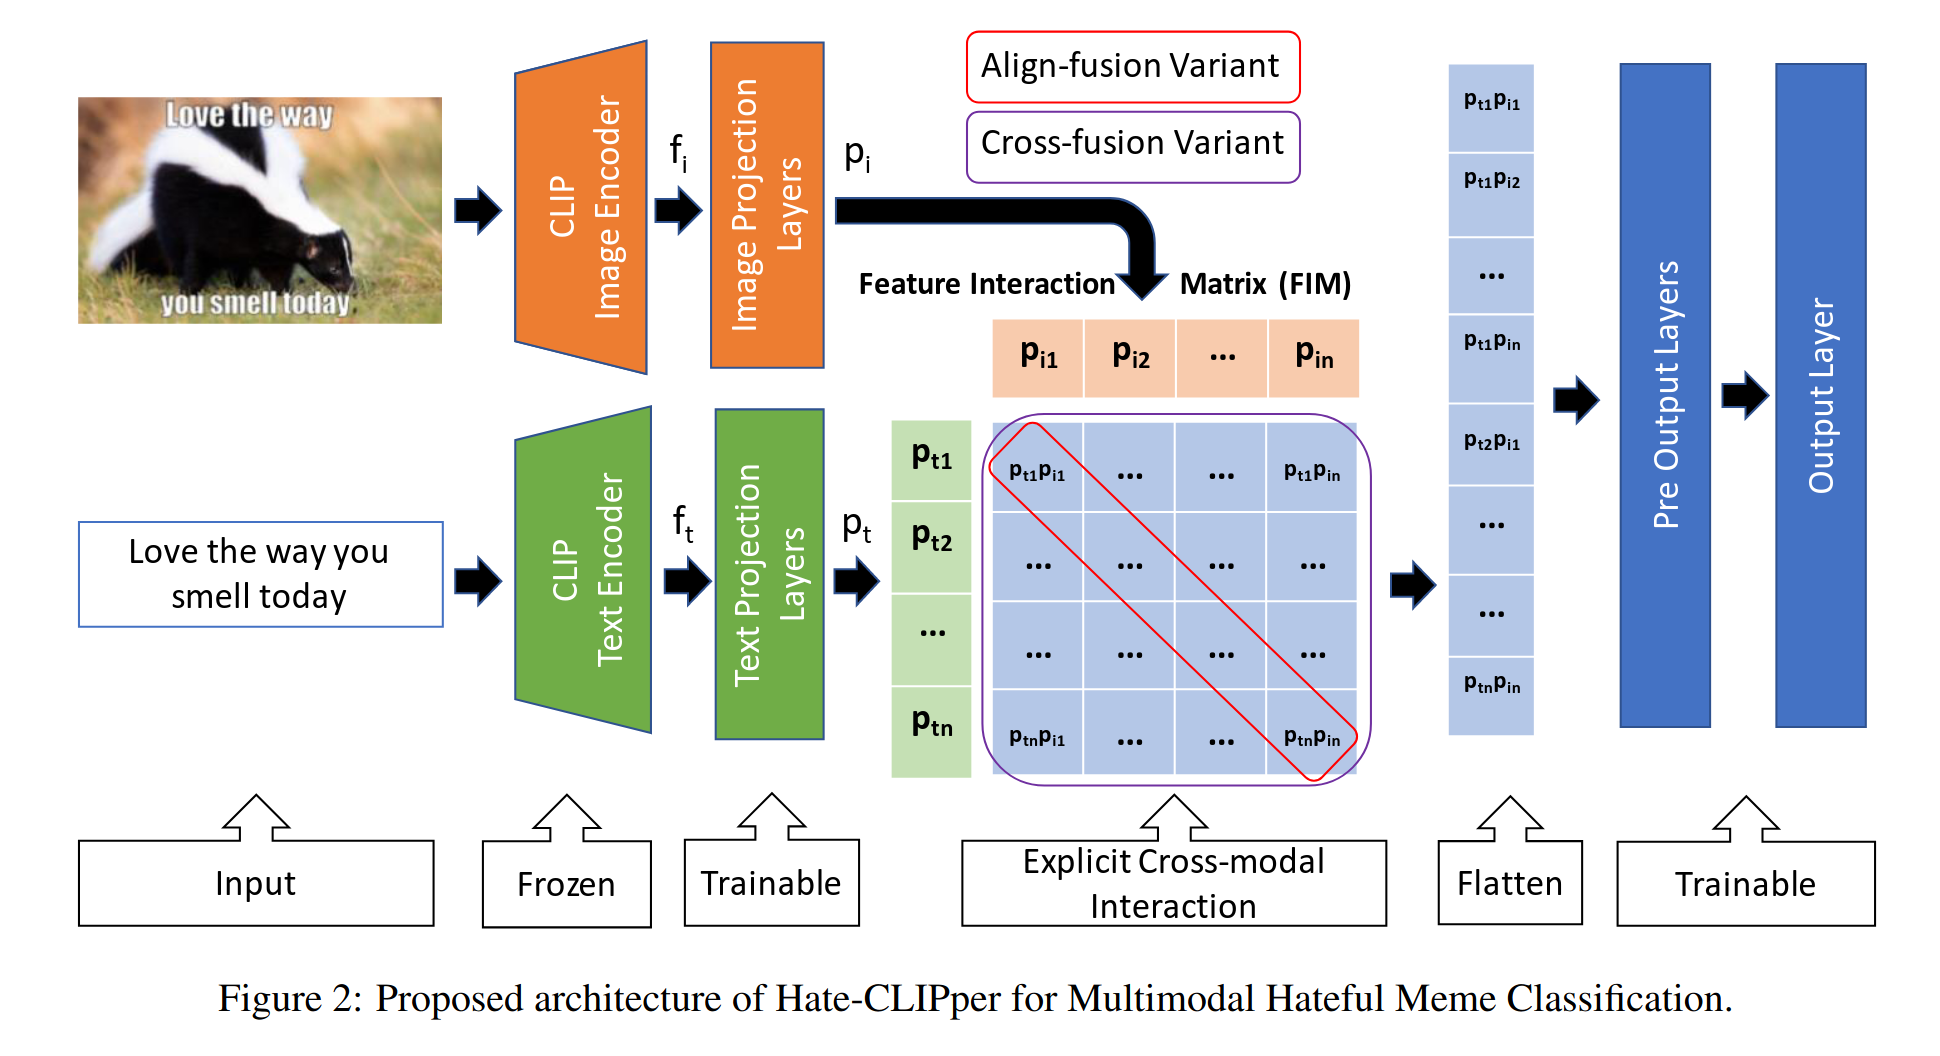

## Thử nghiệm

In [ ]:
class CLIPClassifier(pl.LightningModule):
    def __init__(self, args):
        super().__init__()

        # những tham số cần thiết

        # tham số cần chú ý
        # self.use_pretrained_map = args.use_pretrained_map # Dùng để quyết định có dùng pretrain của Projection layer hay không
        self.local_pretrained_weights = (
            args.local_pretrained_weights
        )  # Dùng để lựa chọn có load bộ weight cũ hay không

        # tham số mô hình
        self.fine_grained_labels = "none"

        self.num_mapping_layers = args.num_mapping_layers

        self.map_dim = args.map_dim

        self.fusion = args.fusion

        # cnn paramater
        self.num_pre_output_layers = args.num_pre_output_layers

        self.lr = args.lr  # learning rate

        self.weight_decay = args.weight_decay
        self.weight_image_loss = args.weight_image_loss
        self.weight_text_loss = args.weight_text_loss
        self.weight_fine_grained_loss = args.weight_fine_grained_loss
        self.weight_super_loss = args.weight_super_loss

        # phần này là để tính loss
        self.acc = torchmetrics.Accuracy(task="binary")
        self.auroc = torchmetrics.AUROC(task="binary")
        self.precision_score = torchmetrics.Precision(task="binary")
        self.recall = torchmetrics.Recall(task="binary")
        self.f1 = torchmetrics.F1Score(task="binary")

        self.clip = CLIPModel.from_pretrained(args.clip_pretrained_model)

        # load state aka checkpoint model
        if args.local_pretrained_weights != "none":
            state_dict = torch.load(args.local_pretrained_weights)["/model-epoch=09-val_loss=0.00.ckpt"]
            state_dict = {
                k[5:]: v for k, v in state_dict.items() if k.startswith("clip")
            }
            self.clip.load_state_dict(state_dict)

            
        # Text encoder model
        config = AutoConfig.from_pretrained(
            args.text_encoder, output_hidden_states=True
        )
        self.text_encoder = AutoModel.from_pretrained(args.text_encoder, config=config).to()

        # Image encoder model
        config = AutoConfig.from_pretrained(
            args.image_encoder, output_hidden_states=True
        )
        self.image_encoder = AutoModel.from_pretrained(
            args.image_encoder, config=config
        )

        # Projection layer
        image_map_layers = [
            nn.Linear(self.image_encoder.vision_model.config.hidden_size, self.map_dim),
            nn.Dropout(p=args.drop_probs[0]),
        ]
        text_map_layers = [
            nn.Linear(self.text_encoder.config.hidden_size, self.map_dim),
            nn.Dropout(p=args.drop_probs[0]),
        ]

        for _ in range(1, self.num_mapping_layers):
            image_map_layers.extend(
                [
                    nn.ReLU(),
                    nn.Linear(self.map_dim, self.map_dim),
                    nn.Dropout(p=args.drop_probs[0]),
                ]
            )
            text_map_layers.extend(
                [
                    nn.ReLU(),
                    nn.Linear(self.map_dim, self.map_dim),
                    nn.Dropout(p=args.drop_probs[0]),
                ]
            )

        self.image_map = nn.Sequential(*image_map_layers)
        self.text_map = nn.Sequential(*text_map_layers)

        # tinh toan khong gian de bien doi
        if args.fusion in ["align", "align_shuffle"]:
            pre_output_input_dim = self.map_dim
        elif args.fusion == "concat":
            pre_output_input_dim = self.map_dim * 2
        elif args.fusion.startswith("cross"):
            pre_output_input_dim = self.map_dim**2
        elif args.fusion == "align_concat":
            pre_output_input_dim = self.map_dim * 3
        elif args.fusion == "attention_m":
            self.gen_query = nn.Linear(self.map_dim, self.map_dim // 4)
            self.gen_key = nn.Linear(self.map_dim, self.map_dim // 4)
            self.soft = nn.Softmax(dim=1)
            pre_output_input_dim = self.map_dim * 2

        # Descrease bias from preoutput matrix
        pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]

        # Preoutput layers
        # pre_output_input_dim, self.map_dim bien doi tu pre sang map dim
        pre_output_layers.extend(
            [
                nn.Linear(pre_output_input_dim, self.map_dim),
                nn.ReLU(),
                nn.Dropout(p=args.drop_probs[2]),
            ]
        )
        output_input_dim = self.map_dim

        # tao cac layer trong cnn cua preoutput layer
        for _ in range(1, self.num_pre_output_layers):  # next pre-output layers
            pre_output_layers.extend(
                [
                    nn.Linear(self.map_dim, self.map_dim),
                    nn.ReLU(),
                    nn.Dropout(p=args.drop_probs[2]),
                ]
            )

        self.pre_output = nn.Sequential(*pre_output_layers)

        # chuyen hoa ket qua thanh 1 hoac 0 binary
        self.output = nn.Linear(output_input_dim, 1)

        # Tao cac preoutput hoc rieng cho anh va chu de co the cai thien
        # khi mot cai trong 2 qua yeu hoac ca 2 qua yeu
        if self.weight_image_loss > 0:
            pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]
            for _ in range(self.num_pre_output_layers):  # next pre-output layers
                pre_output_layers.extend(
                    [
                        nn.Linear(self.map_dim, self.map_dim),
                        nn.ReLU(),
                        nn.Dropout(p=args.drop_probs[2]),
                    ]
                )
            self.pre_output_image = nn.Sequential(*pre_output_layers)
            self.output_image = nn.Linear(output_input_dim, 1)

        if self.weight_text_loss > 0:
            pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]
            for _ in range(self.num_pre_output_layers):  # next pre-output layers
                pre_output_layers.extend(
                    [
                        nn.Linear(self.map_dim, self.map_dim),
                        nn.ReLU(),
                        nn.Dropout(p=args.drop_probs[2]),
                    ]
                )
            self.pre_output_text = nn.Sequential(*pre_output_layers)
            self.output_text = nn.Linear(output_input_dim, 1)

        self.cross_entropy_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')

        if args.freeze_image_encoder:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if args.freeze_text_encoder:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.clip

    def forward(self, batch):
        image_features = self.image_encoder.vision_model(
            pixel_values=batch["pixel_values"]
        ).last_hidden_state[:, 0, :]

        # cho image di qua preoutput
        image_features = self.image_map(image_features)

        # Lấy đặc trưng văn bản từ XLM-Roberta
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        ).last_hidden_state[:, 0, :]

        # cho text di qua preoutput
        text_features = self.text_map(text_features)

        # chuan hoa ca hai feature
        image_features = F.normalize(image_features, p=2, dim=1)  # [batch_size, d]
        text_features = F.normalize(text_features, p=2, dim=1)  # [batch_size, d]

        # fusion lai tat ca va dua ra ket qua
        if self.fusion in ["align", "align_shuffle"]:
            features = torch.mul(image_features, text_features)  # [batch_size, d]
        elif self.fusion == "concat":
            features = torch.cat(
                [image_features, text_features], dim=1
            )  # [batch_size, 2*d]
        elif self.fusion.startswith("cross"):
            features = torch.bmm(
                image_features.unsqueeze(2), text_features.unsqueeze(1)
            )  # [batch_size, d, d]
            if self.fusion == "cross_nd":
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(
                    features.shape[0] * self.map_dim, device=features.device
                )
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]
        elif self.fusion == "align_concat":
            features = torch.cat(
                [
                    torch.mul(image_features, text_features),
                    image_features,
                    text_features,
                ],
                dim=1,
            )  # [batch_size, 3*d]
        elif self.fusion == "attention_m":
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(
                torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1)
            )
            score2 = torch.reshape(
                torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1)
            )
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float())  # prob
            prob_1 = wt_i1_i2[:, 0]
            prob_2 = wt_i1_i2[:, 1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1, wtd_i2), 1)  # [batch_size, 2*d]
        else:
            raise ValueError()

        features = self.pre_output(features)
        logits = self.output(features)

        preds = (torch.sigmoid(logits) >= 0.5).long()
        return preds

    def common_step(self, batch, batch_idx, calling_function="validation"):
        
        image_features = self.image_encoder.vision_model(
            pixel_values=batch["pixel_values"]
        ).last_hidden_state[:, 0, :]

        
        image_features = self.image_map(image_features)

        # Lấy đặc trưng văn bản từ XLM-Roberta
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        ).last_hidden_state[:, 0, :]
        
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1)
        text_features = F.normalize(text_features, p=2, dim=1)

        # Dau ra cho moi epoch
        output = {}

        if self.weight_image_loss > 0:
            features_pre_output = self.pre_output_image(image_features)
            logits = self.output_image(features_pre_output).squeeze(
                dim=1
            )  # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output["image_loss"] = self.cross_entropy_loss(
                logits, batch["labels"].float()
            )
            output["image_accuracy"] = self.acc(preds, batch["labels"])
            output["image_auroc"] = self.auroc(preds_proxy, batch["labels"])

        if self.weight_text_loss > 0:
            features_pre_output = self.pre_output_text(text_features)
            logits = self.output_text(features_pre_output).squeeze(
                dim=1
            )  # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output["text_loss"] = self.cross_entropy_loss(
                logits, batch["labels"].float()
            )
            output["text_accuracy"] = self.acc(preds, batch["labels"])
            output["text_auroc"] = self.auroc(preds_proxy, batch["labels"])

        # CLIP tho nhu mo hinh
        if self.fusion in ["align", "align_shuffle"]:
            features = torch.mul(image_features, text_features)
        elif self.fusion == "concat":
            features = torch.cat([image_features, text_features], dim=1)
        elif self.fusion.startswith("cross"):
            features = torch.bmm(
                image_features.unsqueeze(2), text_features.unsqueeze(1)
            )  # [16, d, d]
            if self.fusion == "cross_nd":
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(
                    features.shape[0] * self.map_dim, device=features.device
                )
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]
        elif self.fusion == "align_concat":
            features = torch.cat(
                [
                    torch.mul(image_features, text_features),
                    image_features,
                    text_features,
                ],
                dim=1,
            )  # [batch_size, 3*d]
        elif self.fusion == "attention_m":
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(
                torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1)
            )
            score2 = torch.reshape(
                torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1)
            )
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float())  # prob
            prob_1 = wt_i1_i2[:, 0]
            prob_2 = wt_i1_i2[:, 1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1, wtd_i2), 1)  # [batch_size, 2*d]
        else:
            raise ValueError()

        # preouput va ouput cho moi epoch
        features_pre_output = self.pre_output(features)
        logits = self.output(features_pre_output).squeeze(dim=1)  # [batch_size, 1(or)n]
        
        preds_proxy = torch.sigmoid(logits)
        preds = (preds_proxy >= 0.5).long()
        
        # loss va acc cho moi epoch
        output["loss"] = self.cross_entropy_loss(logits, batch["labels"].float())
        output["accuracy"] = self.acc(preds, batch["labels"])
        output["auroc"] = self.auroc(preds_proxy, batch["labels"])

        if self.weight_image_loss > 0:
            features_pre_output = self.pre_output_image(image_features)
            logits = self.output_image(features_pre_output).squeeze(
                dim=1
            )  # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output["image_loss"] = self.cross_entropy_loss(
                logits, batch["labels"].float()
            )
            output["image_accuracy"] = self.acc(preds, batch["labels"])
            output["image_auroc"] = self.auroc(preds_proxy, batch["labels"])

        if self.weight_text_loss > 0:
            features_pre_output = self.pre_output_text(text_features)
            logits = self.output_text(features_pre_output).squeeze(
                dim=1
            )  # [batch_size, 1]
            preds_proxy = torch.sigmoid(logits)
            preds = (preds_proxy >= 0.5).long()

            output["text_loss"] = self.cross_entropy_loss(
                logits, batch["labels"].float()
            )
            output["text_accuracy"] = self.acc(preds, batch["labels"])
            output["text_auroc"] = self.auroc(preds_proxy, batch["labels"])

        return output

    def training_step(self, batch, batch_idx):
        output = self.common_step(batch, batch_idx, calling_function="training")

        if self.weight_image_loss > 0:
            image_loss = output["image_loss"]
        else:
            image_loss = 0

        if self.weight_text_loss > 0:
            text_loss = output["text_loss"]
        else:
            text_loss = 0

        loss = {}

        total_loss = (
            output["loss"]
            + self.weight_image_loss * image_loss
            + self.weight_text_loss * text_loss
            + self.weight_super_loss
        )

        self.log('train/total_loss', total_loss)
        self.log('train/loss', output['loss'])
        self.log('train/accuracy', output['accuracy'])
        self.log('train/auroc', output['auroc'])


        if self.weight_image_loss > 0:
            self.log('train/image_loss', image_loss)
        if self.weight_text_loss > 0:
            self.log('train/text_loss', text_loss)
        
        
        loss_out = output['loss']
        acc_out = output['accuracy']
        print(f'Loss: {loss_out}, Accuracy: {acc_out}')

        return total_loss


    def validation_step(self, batch, batch_idx):
        output = self.common_step(batch, batch_idx, calling_function="validation")

        if self.weight_image_loss > 0:
            image_loss = output["image_loss"]
        else:
            image_loss = 0

        if self.weight_text_loss > 0:
            text_loss = output["text_loss"]
        else:
            text_loss = 0

        loss = {}

        total_loss = (
            output["loss"]
            + self.weight_image_loss * image_loss
            + self.weight_text_loss * text_loss
            + self.weight_super_loss
        )

        self.log('train/total_loss', total_loss)
        self.log('train/loss', output['loss'])
        self.log('train/accuracy', output['accuracy'])
        self.log('train/auroc', output['auroc'])


        if self.weight_image_loss > 0:
            self.log('train/image_loss', image_loss)
        if self.weight_text_loss > 0:
            self.log('train/text_loss', text_loss)

        
        return total_loss

    def on_training_epoch_end(self):
        self.acc.reset()
        self.auroc.reset()
        self.precision_score.reset()
        self.recall.reset()
        self.f1.reset()

    def on_validation_epoch_end(self):
        self.acc.reset()
        self.auroc.reset()
        self.precision_score.reset()
        self.recall.reset()
        self.f1.reset()

    def on_test_epoch_end(self):
        self.acc.reset()
        self.auroc.reset()
        self.precision_score.reset()
        self.recall.reset()
        self.f1.reset()
        
        
    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if p.requires_grad]}
            ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

def create_model(args):
    # Set device (GPU or CPU)
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if args.local_pretrained_weights != 'none':
        model = CLIPClassifier.load_from_checkpoint(args.local_pretrained_weights, args=args)
    else:
        model = CLIPClassifier(args=args)

    return model


In [ ]:
seed_everything(42, workers=True)
model = create_model(args)

checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    monitor='train/loss',  # Updated to match the logged metric
    mode='max',
    verbose=True,
    save_last=False,
    save_weights_only=True,
)

trainer = Trainer(
    accelerator="gpu",
    devices = 'auto',
    max_epochs=15,
    gradient_clip_val=0.1,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    deterministic=True,
)


trainer.fit(
        model, dataloader_train, dataloader_validate
)


---

## test dữ liệu 

In [ ]:
# Lặp qua DataLoader và in ra một batch mẫu
for batch in dataloader_train:
    print(type(batch['labels']))
    break  # Chỉ in ra batch đầu tiên để kiểm tra
    
# Lặp qua DataLoader và in ra một batch mẫu
for batch in model.image_map:
    print(batch)
    break  # Chỉ in ra batch đầu tiên để kiểm tra